# The Scaling Plot

<img src="images/scaling-plot.png" width="500px">

We are interested in isolating the behaviour of the error in the structural energy \
as a function of the number of atoms in the structure. We therefore strive to ensure \
that there is no dependence of the difficulty of learning the energy on the number \
of atoms in the structure. We do this by first selecting a subset of the data created \
using similar generation procedures:

## Get the Data

The structural data used in this notebook was published as part of [Phys. Rev. B **95**, 094203](https://doi.org/10.1103/PhysRevB.95.094203)  
and is available from https://www.repository.cam.ac.uk/handle/1810/262814

In [1]:
import re

from ase.io import read
from ase import Atoms


def keep(structure: Atoms) -> bool:
    """
    A filter that will only keep similar structures
    
    Rejects any structure with more than 125 atoms, any structure that is not
    a bulk amorphous structure, and any structure that is not in iteration 2,
    3, or 4 (these all have a similar generation procedure)
    """

    if len(structure) >= 125:
        return False
    if structure.info["config_type"] != "bulk_amo":
        return False
    return bool(re.match(r"iter[234]", structure.info["detailed_ct"]))


GAP17_train_structures = read('GAP17-train.extxyz', index=':')
structures = [s for s in GAP17_train_structures if keep(s)]

len(structures)  # this leaves us with 1648 structures

1648

Now we want to extract the useful information from the structures. \
We can use a pandas DataFrame:

In [2]:
import pandas as pd


def extract_information(structure: Atoms):
    """get the number of atoms, the DFT energy, and the GAP17 energy"""
    
    return dict(
        N=len(structure),
        dft_energy=structure.info["energy"],
        gap_energy=structure.arrays["gap17_energy"].sum(),
    )


df = pd.DataFrame([extract_information(s) for s in structures])
df['absolute_error'] = (df.gap_energy - df.dft_energy).abs()
df.head()

,N,dft_energy,gap_energy,absolute_error
0,48,-7502.902288,-7503.078693,0.176405
1,48,-7508.574790,-7510.463381,1.888591
2,48,-7500.614073,-7503.090607,2.476534
3,36,-5632.093988,-5634.036845,1.942857
4,64,-10015.083311,-10017.582613,2.499302


## Basic Plotting

We can make some basic plots to see how the relationship between error and \
the number of atoms in the structure changes as we change the scaling of the error:

In [3]:
mae_by_N = df.groupby('N').absolute_error.mean().reset_index()
mae_by_N

,N,absolute_error
0,27,0.915583
1,36,1.189572
2,48,1.376361
3,64,1.612555
4,80,1.770302
5,100,2.049550


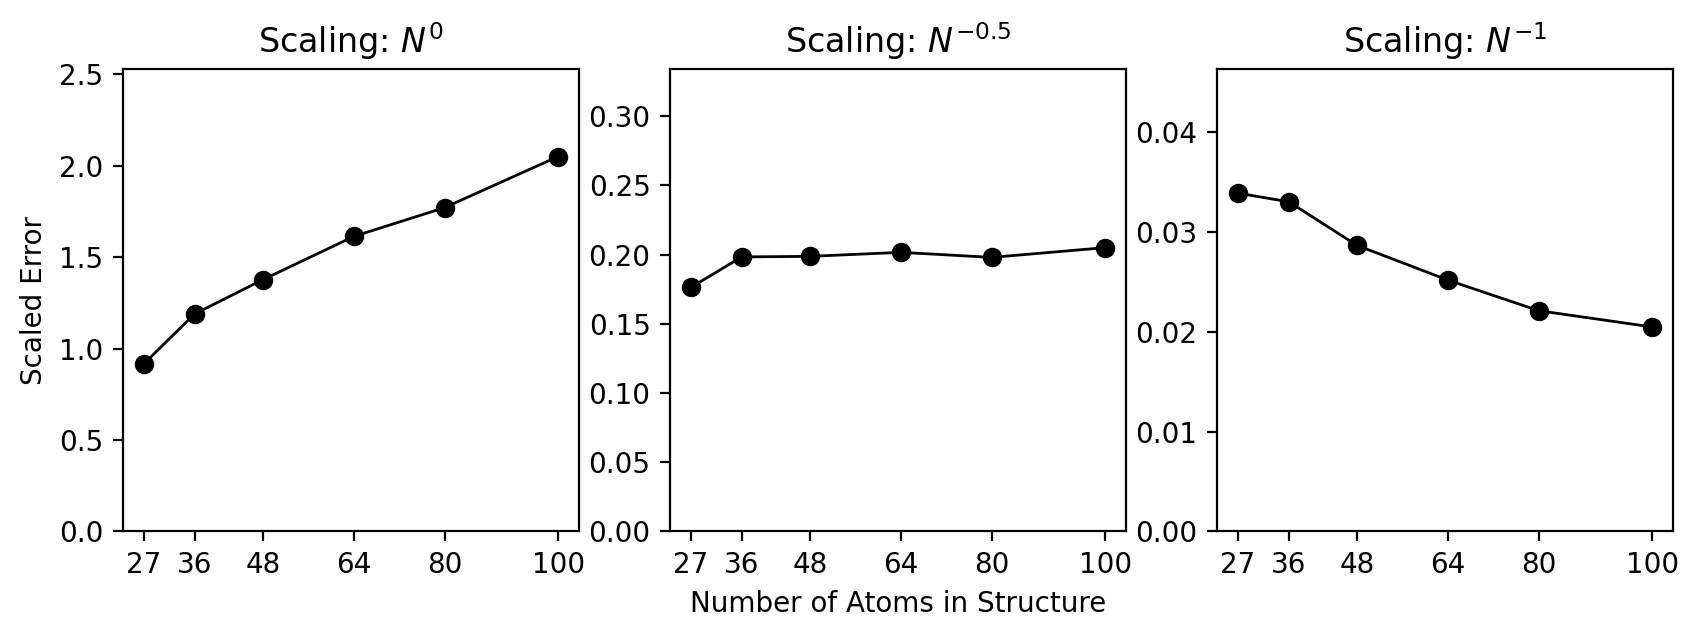

In [4]:
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.family'] = 'sans-serif'


scalings = [0, -0.5, -1]
_, axs = plt.subplots(ncols=len(scalings), figsize=(10, 3))
N, mae = mae_by_N.N, mae_by_N.absolute_error

for scaling, ax in zip(scalings, axs):
    error = mae / (N ** -scaling)
    ax.plot(N, error, "-ok", linewidth=1)

    ax.set_xticks(N)
    ax.set_ylim(bottom=0, top=error.mean() * 1.7)
    ax.set_title(f"Scaling: $N^{{{scaling}}}$")

axs[0].set_ylabel("Scaled Error")
axs[1].set_xlabel("Number of Atoms in Structure");

## Violin Plots

We provide here some useful functions for plotting error distributions:

Some basic usage:

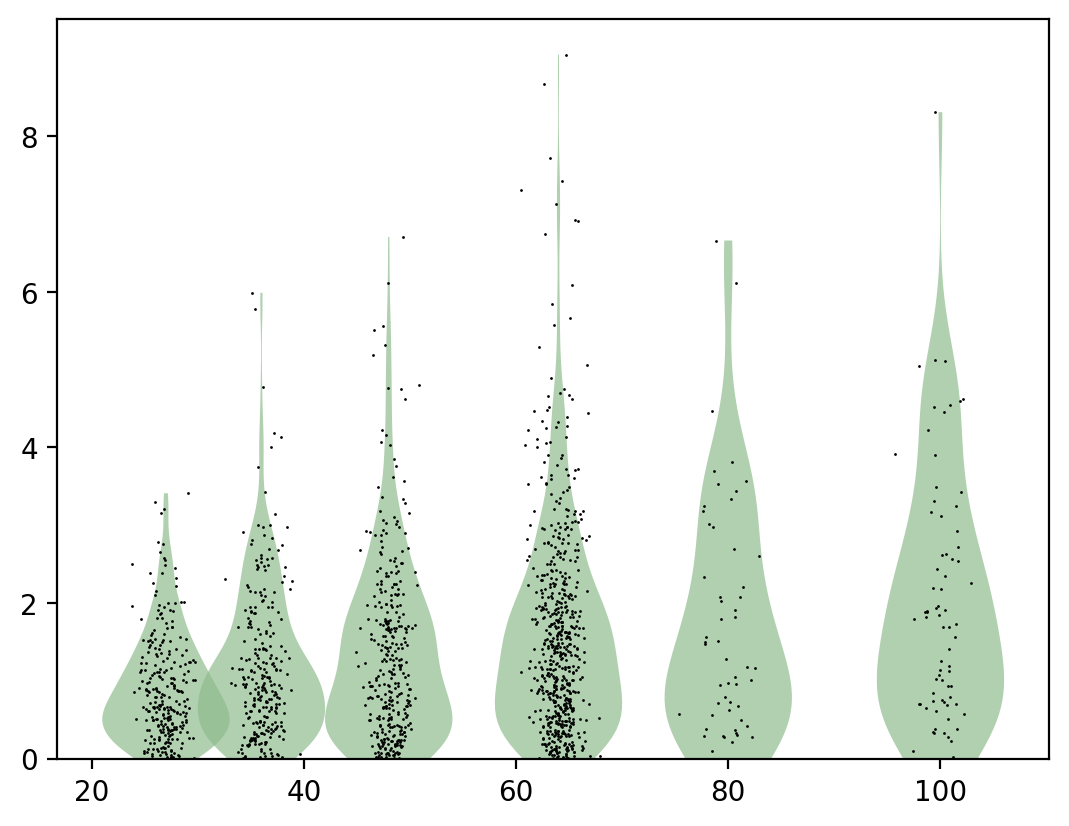

In [5]:
from share.plotting import violin, rain_cloud

violin(df.N, df.absolute_error, widths=12, force_to_zero=True)
rain_cloud(df.N, df.absolute_error, strength=1.2)

Recreating the plot from the paper:

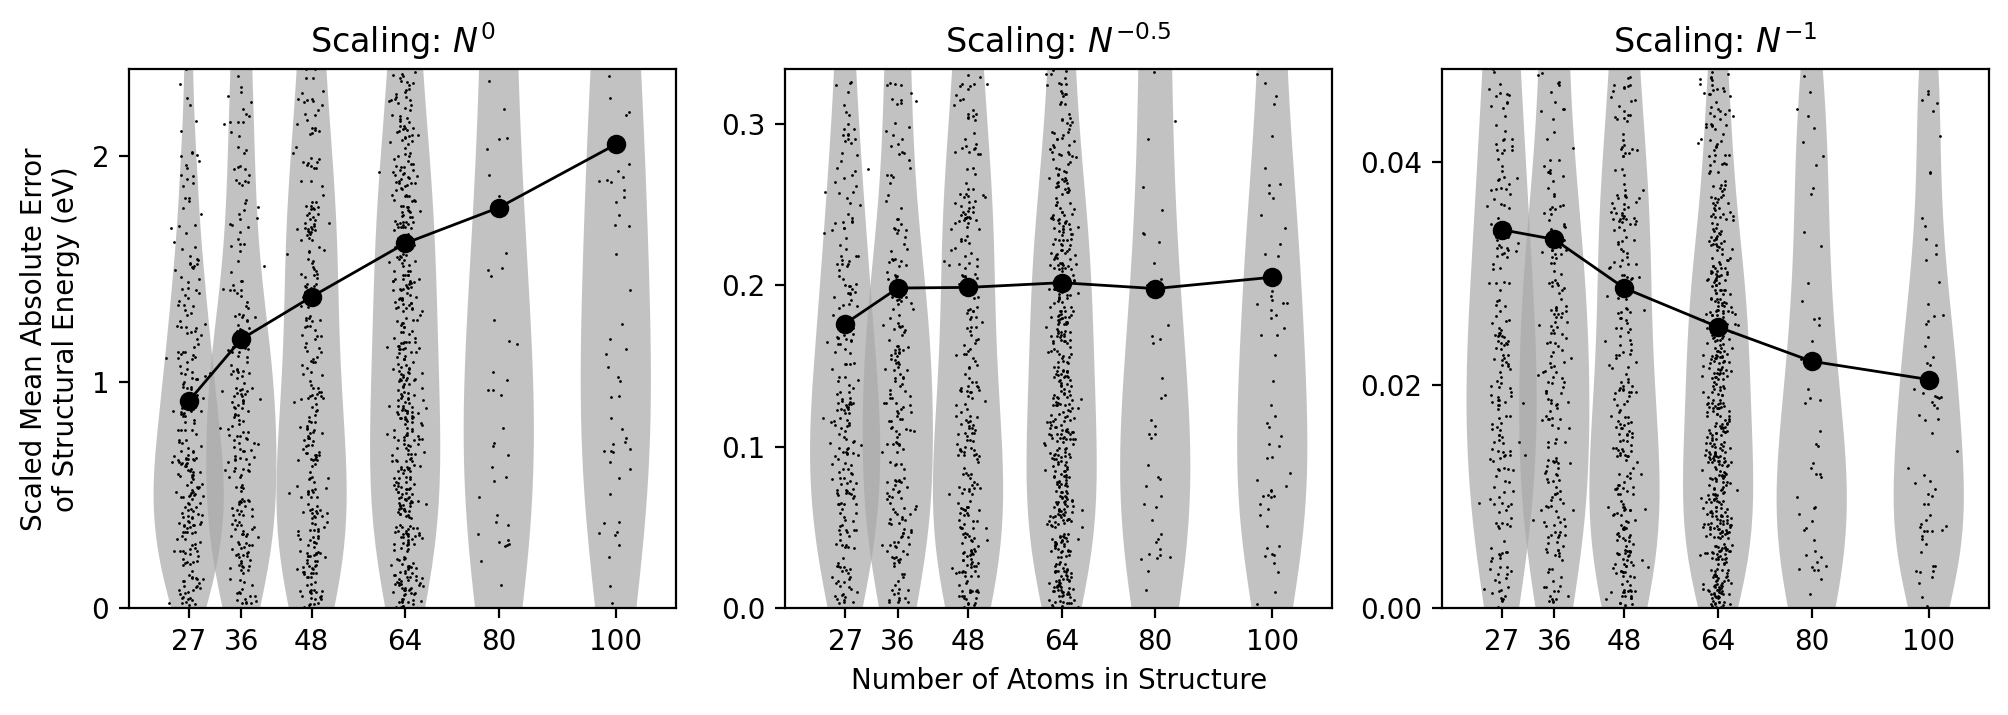

In [7]:
scalings = [0, -0.5, -1]

_, axs = plt.subplots(ncols=len(scalings), figsize=(12, 3.5))
N, mae = mae_by_N.N, mae_by_N.absolute_error

for scaling, ax in zip(scalings, axs):
    error_by_N = mae / (N ** -scaling)
    ax.plot(N, error_by_N, "-ok", linewidth=1)

    error = df.absolute_error / (df.N ** -scaling)
    violin(df.N, error, ax=ax, widths=12, force_to_zero=True, color="darkgray")
    rain_cloud(df.N, error, ax=ax, strength=1.2)

    ax.set_xticks(N)
    ax.locator_params(axis='y', nbins=4)
    ax.set_ylim(bottom=0, top=error.mean() * 1.7)
    ax.set_title(f"Scaling: $N^{{{scaling}}}$")

axs[0].set_ylabel("Scaled Mean Absolute Error\nof Structural Energy (eV)")
axs[1].set_xlabel("Number of Atoms in Structure")

plt.savefig("images/scaling-plot.png", bbox_inches="tight", dpi=300);